# Analyze number, size, and shape of stomata using interactive PlantCV tools
In this notebook we analyze brightfield microscopy images of plant stomata. First, the stoma are detected automatically using a color threshold; however, for most images this is insufficient to remove noise and get an accurate stomata count, depending on the quality of the images. Next, interactive tools can be used to select only the stomata. Lastly, the morphology package provides analysis of shape, including aperture (area), length (height), and width. Data is then exported as a .csv for downstream analysis. Stomatal conductance is a function of both the number of stoma and their aperture. 


## Import libraries and define local functions

In [3]:
from matplotlib import pyplot as plt
from plantcv import plantcv as pcv
import cv2
import numpy as np
import argparse 
from  matplotlib import pyplot as plt
import os
from skimage import exposure, img_as_float
import glob
import pandas as pd

%matplotlib widget

In [4]:
pcv.__version__

#This tutorial is made specifically for version 4 and above

'4.0.1'

In [5]:
# Input/output options
class options:
    def __init__(self):
        self.image = "./imgs/SCALE_20x_1201_C_WT_4_001.tif"  # required
        self.debug = "plot"  # None, "print" (save to file), or "plot" (display in notebook)
        self.writeimg= False
        self.result = "example_results_oneimage_file.csv"  # required
        self.outdir = "." # Store the output to the current directory 

#Images in the format of .tif or .jpg are usable in this workflow. 
#We recommend keeping a spreadsheet with your image names so you can copy and paste them into the notebook one image at a time. 

# Get options
args = options()

In [6]:
# Set debug to the global parameter 
pcv.params.debug = args.debug
# Change display settings
pcv.params.dpi = 120
pcv.params.text_size = 10

## Load image and threshold 
The channel used and the threshold value can be adjusted for a better result. The resulting binary image from this step must contain all the stomata. The additional noise from other cells and shadows in the image will be removed in a subsequent step. 

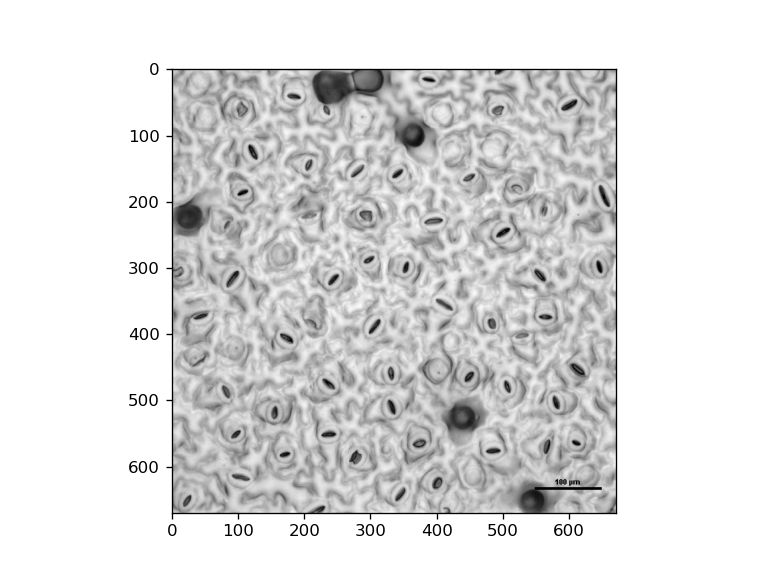

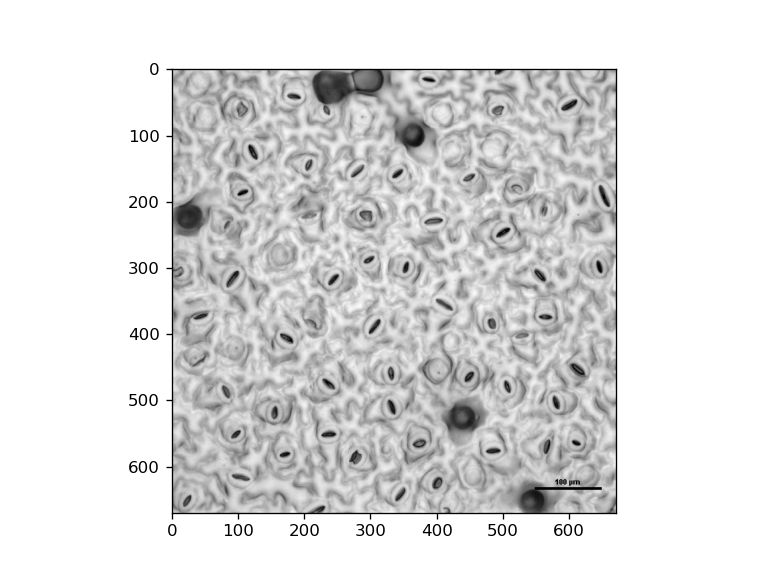

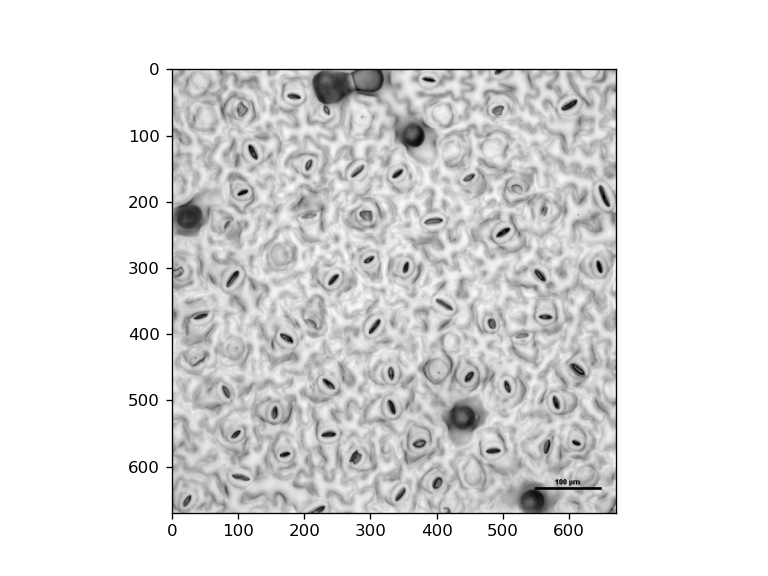

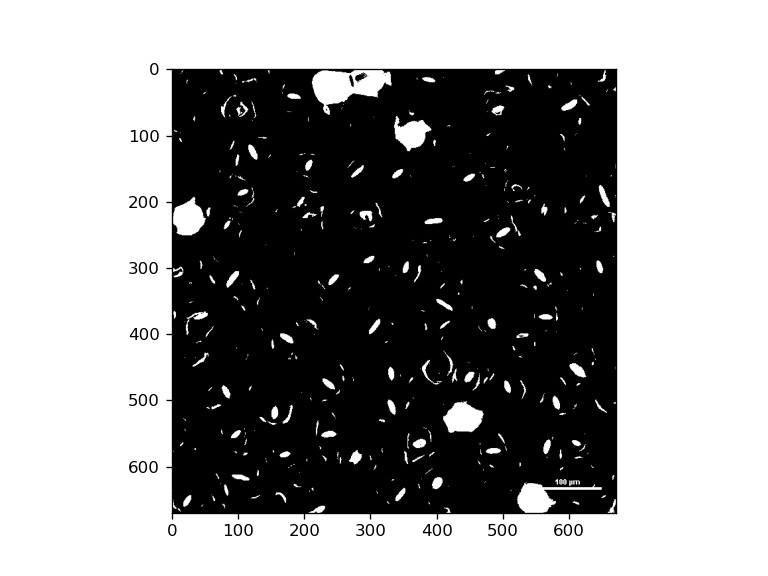

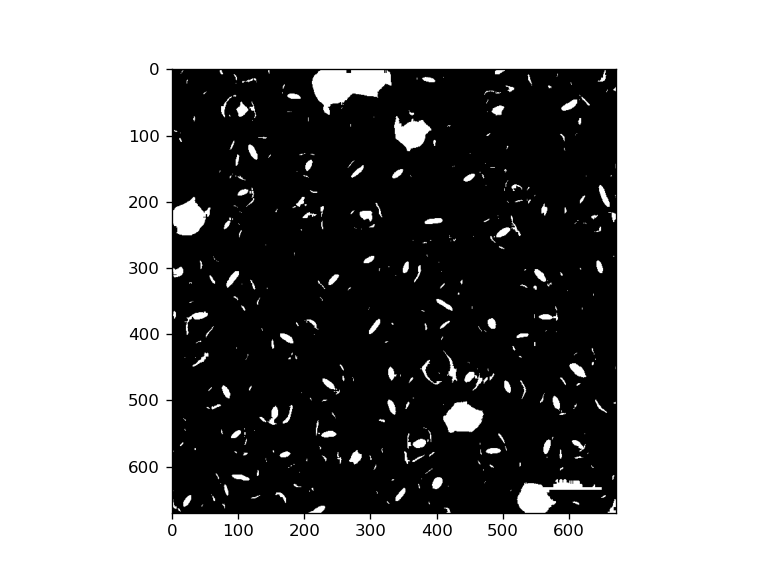

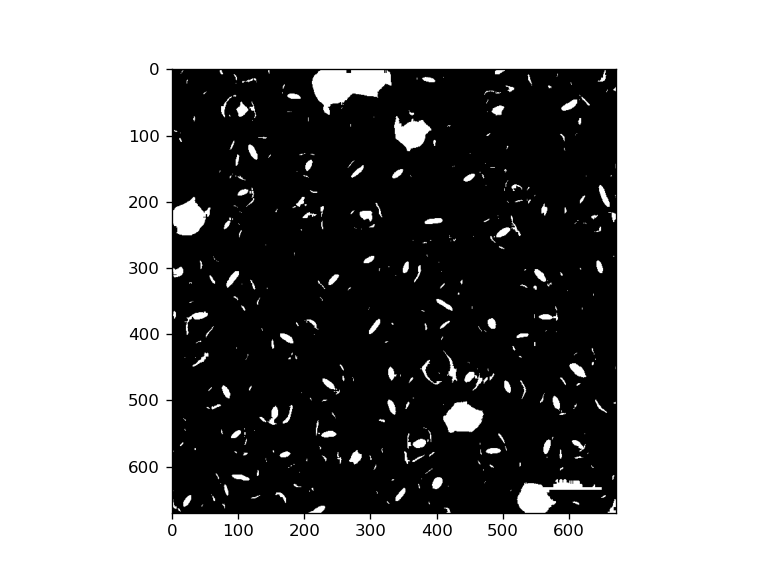

Text(0.5, 1.0, 'Binary image containing all the stomata')

In [8]:
img, _, filename = pcv.readimage(filename=args.image, mode="native")
h,w,_ = img.shape

pcv.plot_image(img)
plt.title('RGB')

img_l = pcv.rgb2gray_lab(rgb_img=img, channel='l')

# Threshold the l channel image to get only the stomata
#If you don't like this threshold, you can try the other channels (a, l, v, s)
l_thresh = pcv.threshold.binary(gray_img=img_l, threshold=135, 
                                object_type='dark')

# post-processing for cleaning to fill in the center of the stomata
cross_kernel = pcv.get_kernel(size=(10,10), shape="cross")
l_fill_image = pcv.closing(gray_img=l_thresh, kernel = cross_kernel)

# look at the cleaned image and see if you have all the stomata, fully filled in.
pcv.plot_image(l_fill_image)
plt.title('Binary image containing all the stomata')

## Initialize interactive tool and use pre-detected stoma
Click to select only the stomata. You will need to click only once per stomata, and only inside or close to the dark center of the stoma. Your clicking does not have to be perfectly in the center of the stomata. If you click incorrectly, you can click again on the incorrect point to remove it. Adjust figsize for zoom as needed using the interactive figure. 

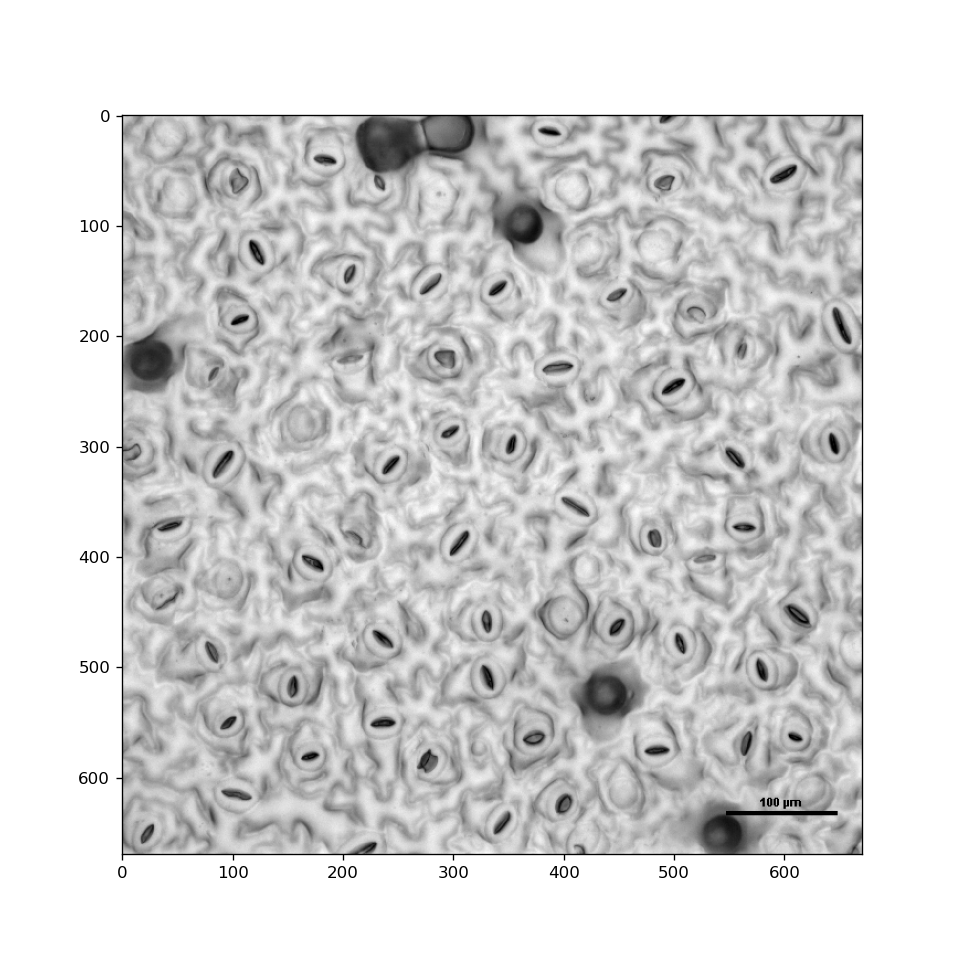

In [9]:
#collect points for center of ROIs by clicking on each stomata. You do not need to click perfectly in them, just in or close to the dark center of the stomata
marker = pcv.Points(img, figsize=(8,8))

## Look at how many stomata you clicked in your image. You can analyze the number of stomata in your output .csv and do not need to record this unless you want to look at it sooner. 

In [10]:
# This function measures the length of the list of marker points
len(marker.points)

4

## Create Regions of Interest (ROIs) around each of the markers you clicked, this will select only the stomata to move forward

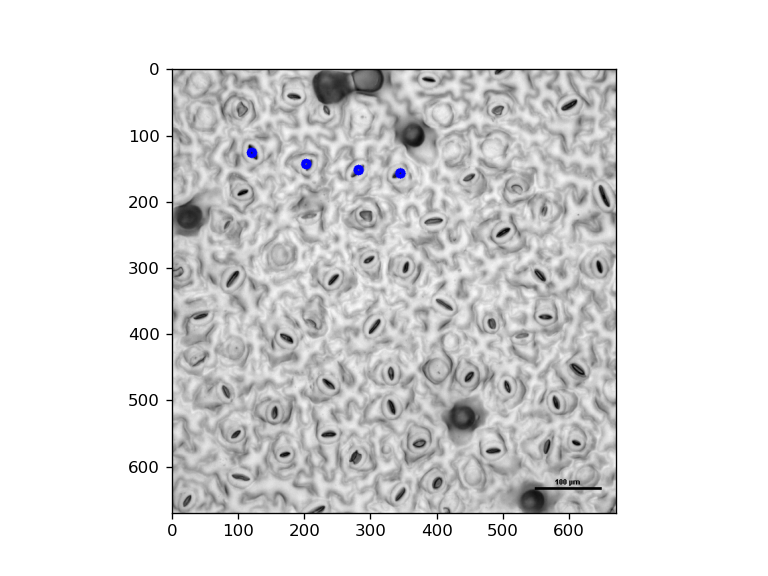

In [12]:
# Create ROI based on the selected points
# Your ROI will show up as blue circles here. 
roi = pcv.roi.multi(img=img, coord=marker.points, radius=5)

## Label each stomata 

In [17]:
# Label the objects in your region of interest and number them
# Each object should be a different color. If your objects are the same color and/or are touching, go back to your mask 
# so that they are separate or it will treat them as a single object
# labeled_objects here is a mask

labeled_objects, n_obj = pcv.create_labels(mask=l_fill_image, rois=roi, roi_type="partial")

## Set the label for each image so that the individual stomata are labeled both with a number and with which plant and treatment they come from
pcv.params.sample_label = "image_label"


## Analyze the size and shape of each stomata

In [18]:
############### Analysis ################ 
  
# Find shape properties, data gets stored to an Outputs class automatically

# Inputs:
#   img - RGB or grayscale image data 
#   labeled_mask - the mask of each individual object, set by the create_labels function. 
#   n_labels - the number of objects, set by the create_labels function. 

analysis_image = pcv.analyze.size(img=img, labeled_mask=labeled_objects, n_labels=n_obj)

## Calibration: Your output csv will be in units of pixels. In order to convert from pixels to other units, measure your scale bar. You should copy these values down to use in your downstream analysis, your results file will still show measurements in pixels. If you want to remain in pixels you can skip this step. 

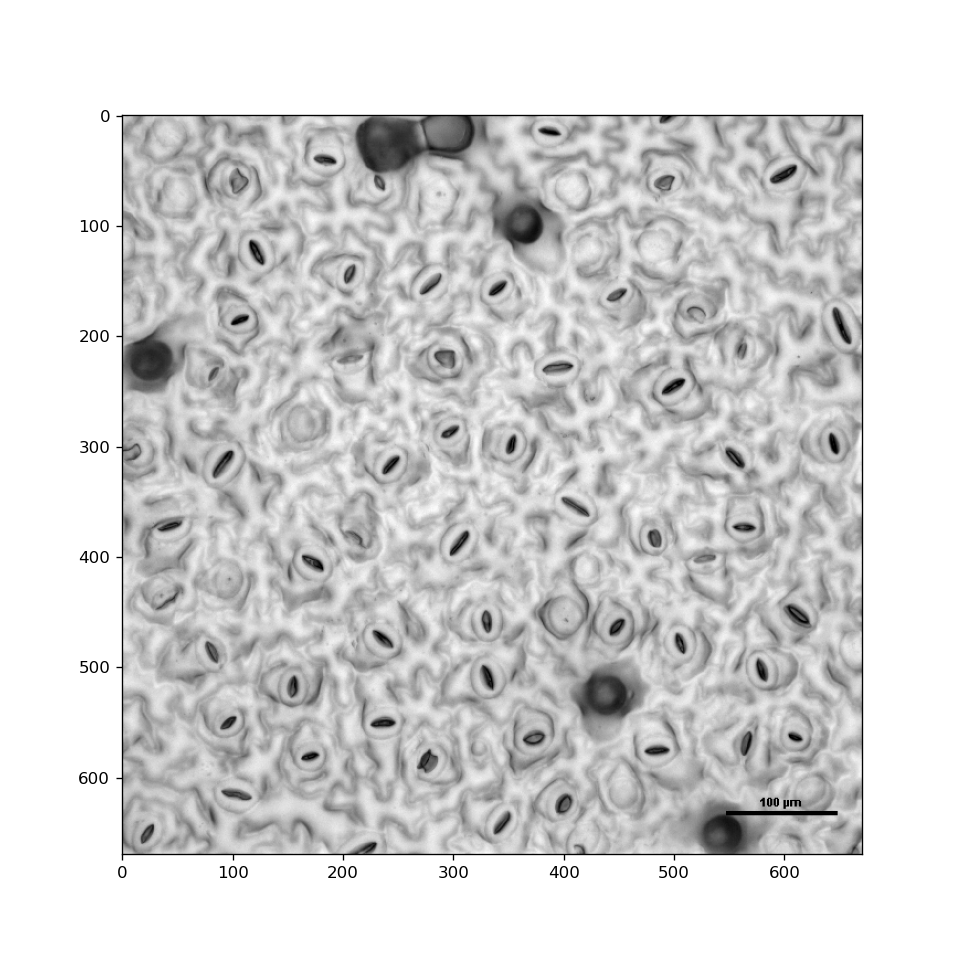

In [20]:
# Collect points using your mouse click for the left and right edges of your scale bar. 
scale_bar = pcv.Points(img, figsize=(8,8))


In [21]:
# Use the x coordinate of the two points to get the equivalence between pixels and the image units.
# get x coordinates
x0 = scale_bar.points[0][0]
x1 = scale_bar.points[1][0]
print(f"The x coordinate of the two extremes of the scale bar are {x0} and {x1} respectively")

# calculate pixel equivalence 
scale = 100 # change this number to equal the micrometers in the image
bar_len_pix = x1-x0
print(f"The length in pixels of the scale bar is {bar_len_pix}")
one_pixel_in_units = scale/bar_len_pix
print(f"1 pixel is equivalent to {one_pixel_in_units} units")
print(f"Your .csv file will have data in pixel units, you can convert using this information when you analyze the numerical data")

The x coordinate of the two extremes of the scale bar are 548 and 645 respectively
The length in pixels of the scale bar is 97
1 pixel is equivalent to 1.0309278350515463 units
Your .csv file will have data in pixel units, you can convert using this information when you analyze the numerical data


## Save the results file and any image files you would like. "Plot" shows you the image here, "Print" saves the image to your designated folder. If you save out the masks, you can use these later for building deep learning pipelines of annotated images. 

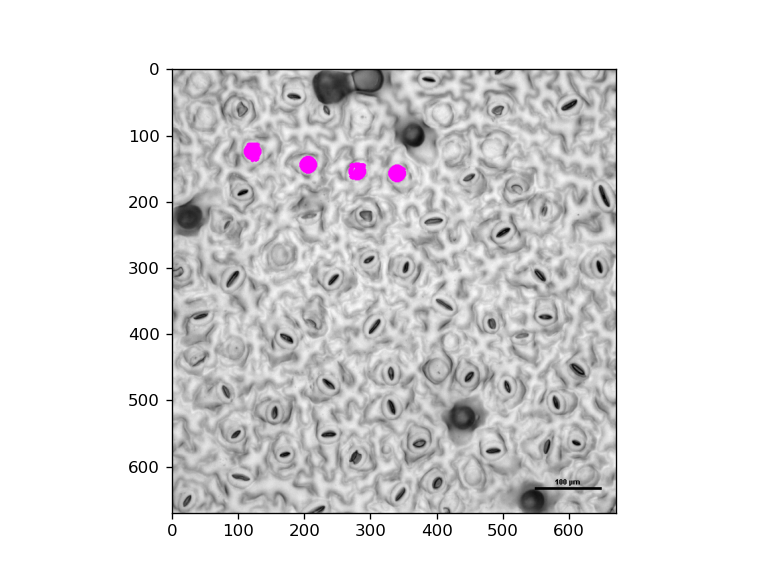

In [24]:
# Save the outputs as a csv
pcv.outputs.save_results(filename=args.result, outformat = "csv")

#plot the image with the analysis overlay so that you can see what it looks like and make sure the stomata are all included and that the measurement outline is around the stoma
pcv.plot_image(analysis_image)

#save the mask image file if you would like to use it later for building deep learning applications
pcv.print_image(labeled_objects, filename = os.path.join(args.outdir, filename[:-4] + '_mask.png' ))

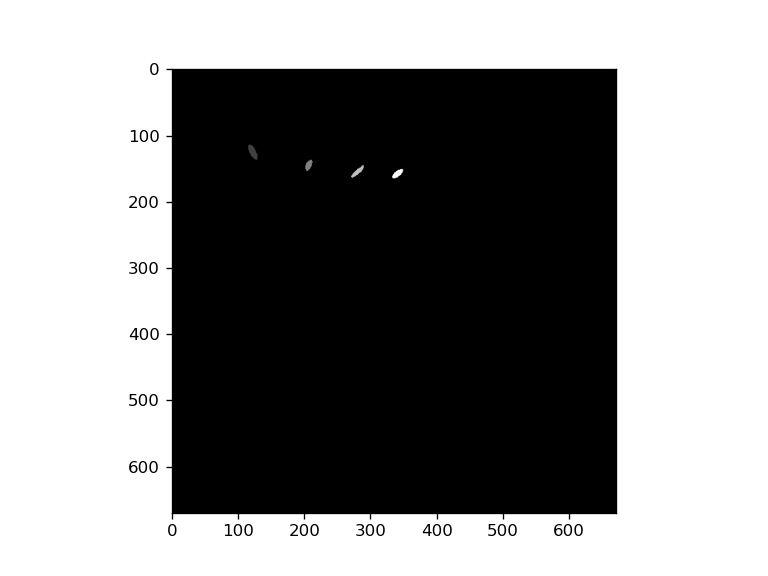

In [26]:
img, _, filename = pcv.readimage(filename="SCALE_20x_1201_C_WT_4_001_mask.png", mode="native")
pcv.plot_image(img)

## Clear the outputs before you start on a new image so that each image has its own .csv file! 

In [23]:
#clear outputs
pcv.outputs.clear()

## After you have done multiple images, combine the .csv files from each image into a single file for analysis

In [ ]:
# define the path to the individual result .csv files
path = 'args.outdir'
os.chdir(path)

#select which files should be combined
all_filenames = [i for i in glob.glob('*.{}'.format('csv'))]

#combine the individual .csv files
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
combined_csv.to_csv( "combined_results.csv", index=False, encoding='utf-8-sig')